In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from plotly.offline import iplot

import pickle

In [2]:
cf.go_offline()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
pr = ProfileReport(df)

In [5]:
pr.to_file("diabetes_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
pr.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
X = df.drop(columns = ['Outcome'])
X.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.127964,0.208984,0.013376,-0.018082,0.021546,-0.033523,0.544341
Glucose,0.127964,1.000000,0.219666,0.160766,0.396597,0.231478,0.137106,0.266600
BloodPressure,0.208984,0.219666,1.000000,0.134155,0.010926,0.281231,0.000371,0.326740
SkinThickness,0.013376,0.160766,0.134155,1.000000,0.240361,0.535703,0.154961,0.026423
Insulin,-0.018082,0.396597,0.010926,0.240361,1.000000,0.189856,0.157806,0.038652
BMI,0.021546,0.231478,0.281231,0.535703,0.189856,1.000000,0.153508,0.025748
DiabetesPedigreeFunction,-0.033523,0.137106,0.000371,0.154961,0.157806,0.153508,1.000000,0.033561
Age,0.544341,0.266600,0.326740,0.026423,0.038652,0.025748,0.033561,1.000000


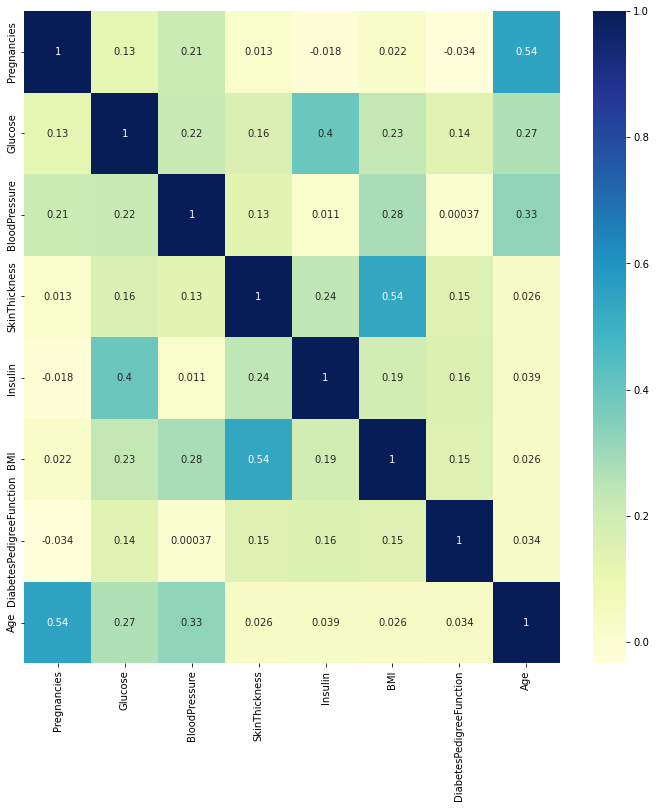

In [20]:
fig = plt.figure()
fig.set_size_inches(12, 12)

# plotting correlation heatmap
sns.heatmap(X.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [22]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Since there are so many zeroes where they were not supposed to be, it's advisable to replace them w median or mode and as such, most of the data is skewed so it's better to go ahead with median instead of mean.

In [23]:
# Imputing the missing vals with median 

df['Glucose'].replace(0, df['Glucose'].median(), inplace=True)

In [16]:
def replace_zeroes(col):
    df[col].replace(0, df[col].mean(), inplace=True)

In [17]:
replace_zeroes('BloodPressure')
replace_zeroes('SkinThickness')
replace_zeroes('Insulin')
replace_zeroes('BMI')

In [18]:
ProfileReport(df).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Let's go and deal with the outliers now:

In [15]:
df.iplot(kind='box')

<AxesSubplot:>

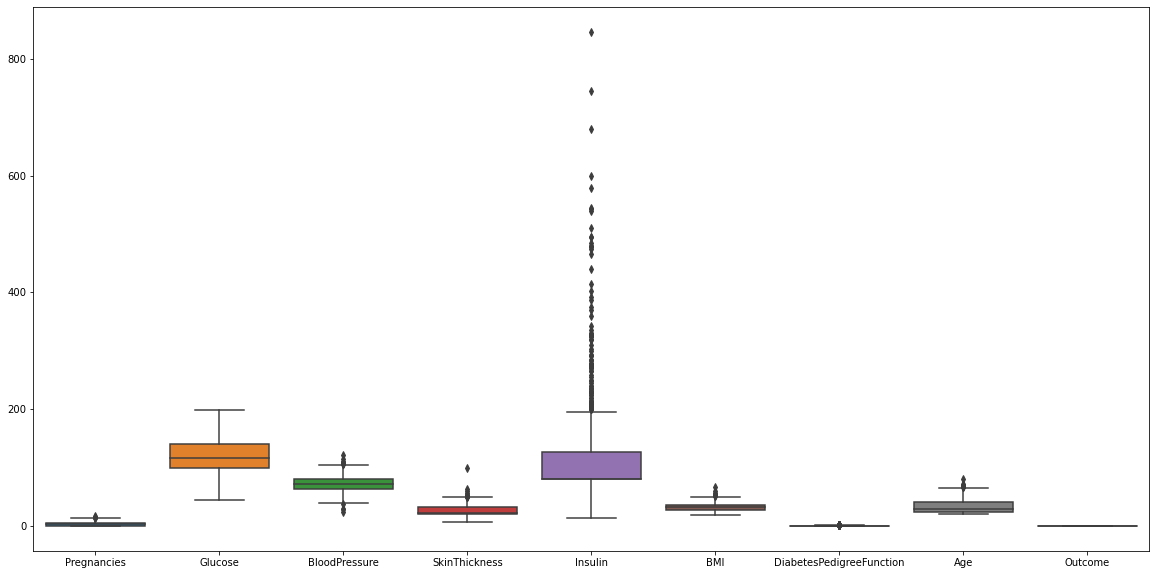

In [16]:
fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = df)

In [24]:
df_new = df.copy(deep=True)
df_new.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


### # Quantile:
- **Quantiles are basically the values that split sorted data or a probability distribution into equal parts.**
- **q-quantile** will divide the sorted data into **q equal parts**.

**Note: df.quantile() is finding the percentiles only. Do not let it get you by the name.**

In [25]:
q = df['Pregnancies'].quantile(.98) # 12.0 i.e. 98 percentile value!
print(q)
df_new = df_new[df_new['Pregnancies'] < q]
      
q = df['BloodPressure'].quantile(.98) 
df_new = df_new[df_new['BloodPressure'] < q]
q = df['BloodPressure'].quantile(.22) 
df_new = df_new[df_new['BloodPressure'] > q]

q = df['SkinThickness'].quantile(.98) 
df_new = df_new[df_new['SkinThickness'] < q]

q = df['BMI'].quantile(.98) 
df_new = df_new[df_new['BMI'] < q]

q = df['DiabetesPedigreeFunction'].quantile(.9) 
df_new = df_new[df_new['DiabetesPedigreeFunction'] < q]

q = df['Age'].quantile(.98) 
df_new = df_new[df_new['Age'] < q]

# q = df['BloodPressure'].quantile(.97) 
# df_new = df_new[df_new['BloodPressure'] < q]

12.0


In [26]:
q = df['BloodPressure'].quantile(.97) 
df_new = df_new[df_new['BloodPressure'] < q]

<AxesSubplot:>

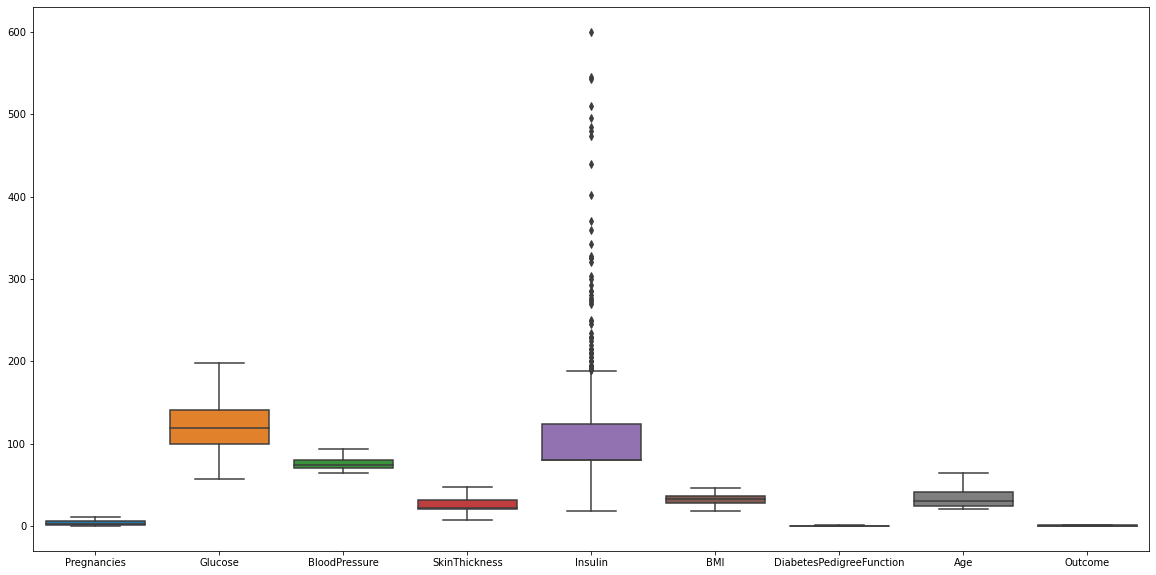

In [27]:
fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = df_new)

In [28]:
df_new

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.000000,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.000000,29.000000,79.799479,26.6,0.351,31,0
3,1,89.0,66.000000,23.000000,94.000000,28.1,0.167,21,0
5,5,116.0,74.000000,20.536458,79.799479,25.6,0.201,30,0
7,10,115.0,69.105469,20.536458,79.799479,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
758,1,106.0,76.000000,20.536458,79.799479,37.5,0.197,26,0
761,9,170.0,74.000000,31.000000,79.799479,44.0,0.403,43,1
764,2,122.0,70.000000,27.000000,79.799479,36.8,0.340,27,0
765,5,121.0,72.000000,23.000000,112.000000,26.2,0.245,30,0


In [29]:
df_new.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [30]:
# features

X = df_new.drop(columns = ['Outcome'])
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.000000,35.000000,79.799479,33.6,0.627,50
1,1,85.0,66.000000,29.000000,79.799479,26.6,0.351,31
3,1,89.0,66.000000,23.000000,94.000000,28.1,0.167,21
5,5,116.0,74.000000,20.536458,79.799479,25.6,0.201,30
7,10,115.0,69.105469,20.536458,79.799479,35.3,0.134,29
...,...,...,...,...,...,...,...,...
758,1,106.0,76.000000,20.536458,79.799479,37.5,0.197,26
761,9,170.0,74.000000,31.000000,79.799479,44.0,0.403,43
764,2,122.0,70.000000,27.000000,79.799479,36.8,0.340,27
765,5,121.0,72.000000,23.000000,112.000000,26.2,0.245,30


In [31]:
# label

Y = df_new['Outcome']
Y

0      1
1      0
3      0
5      0
7      0
      ..
758    0
761    1
764    0
765    0
767    0
Name: Outcome, Length: 439, dtype: int64

In [32]:
from scipy import stats

In [33]:
insulin_boxcoxed, lambdA = stats.boxcox(df_new['Insulin'])
print(lambdA)
insulin_boxcoxed

-0.4165105758401917


array([2.01348942, 2.01348942, 2.03903545, 2.01348942, 2.01348942,
       2.226598  , 2.01348942, 2.01348942, 2.12156471, 2.01348942,
       2.15161832, 2.01348942, 2.04219475, 2.1538413 , 2.01348942,
       2.01348942, 2.01348942, 2.0996695 , 2.06818508, 2.01348942,
       2.09435816, 2.01348942, 2.01348942, 2.15809252, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01785402,
       1.75047038, 2.17773407, 2.18958687, 2.17896183, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       1.87321121, 2.04824217, 2.03242165, 2.16772267, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       1.99417028, 2.01348942, 2.07954168, 1.99417028, 2.01348942,
       2.12222687, 1.92213793, 2.01348942, 1.97620075, 2.15070987,
       1.88436527, 1.86119308, 2.08967947, 1.86731718, 2.01348942,
       2.01348942, 1.93407568, 2.04824217, 2.01348942, 2.08967

<AxesSubplot:>

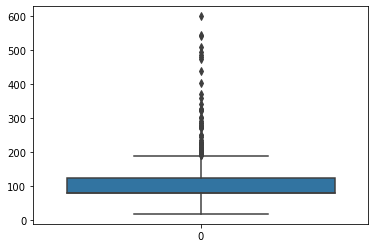

In [34]:
sns.boxplot(data = X['Insulin'])

<AxesSubplot:>

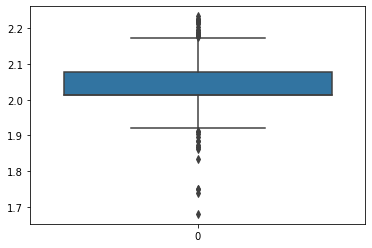

In [35]:
sns.boxplot(data=insulin_boxcoxed)

<AxesSubplot:>

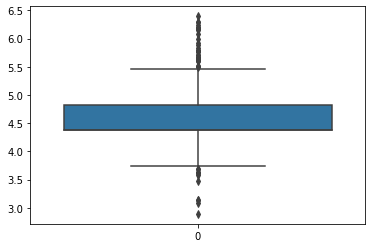

In [36]:
sns.boxplot(data = np.log(X['Insulin']))

<AxesSubplot:>

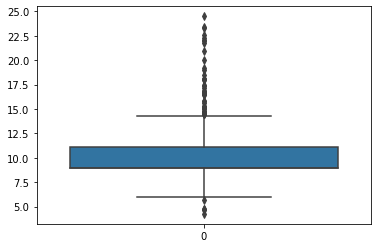

In [37]:
sns.boxplot(data = np.sqrt(X['Insulin']))

### __> BoxCoxed Insulin is showing the best results comparitively!

In [38]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.000000,35.000000,79.799479,33.6,0.627,50
1,1,85.0,66.000000,29.000000,79.799479,26.6,0.351,31
3,1,89.0,66.000000,23.000000,94.000000,28.1,0.167,21
5,5,116.0,74.000000,20.536458,79.799479,25.6,0.201,30
7,10,115.0,69.105469,20.536458,79.799479,35.3,0.134,29


In [39]:
X['Insulin'] = insulin_boxcoxed

In [40]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.000000,35.000000,2.013489,33.6,0.627,50
1,1,85.0,66.000000,29.000000,2.013489,26.6,0.351,31
3,1,89.0,66.000000,23.000000,2.039035,28.1,0.167,21
5,5,116.0,74.000000,20.536458,2.013489,25.6,0.201,30
7,10,115.0,69.105469,20.536458,2.013489,35.3,0.134,29
...,...,...,...,...,...,...,...,...
758,1,106.0,76.000000,20.536458,2.013489,37.5,0.197,26
761,9,170.0,74.000000,31.000000,2.013489,44.0,0.403,43
764,2,122.0,70.000000,27.000000,2.013489,36.8,0.340,27
765,5,121.0,72.000000,23.000000,2.064502,26.2,0.245,30


In [41]:
# q = X['Insulin'].quantile(.99)
# X = X[X['Insulin']<q]

# q = X['Insulin'].quantile(.2)
# X = X[X['Insulin']>q]

# X

<AxesSubplot:>

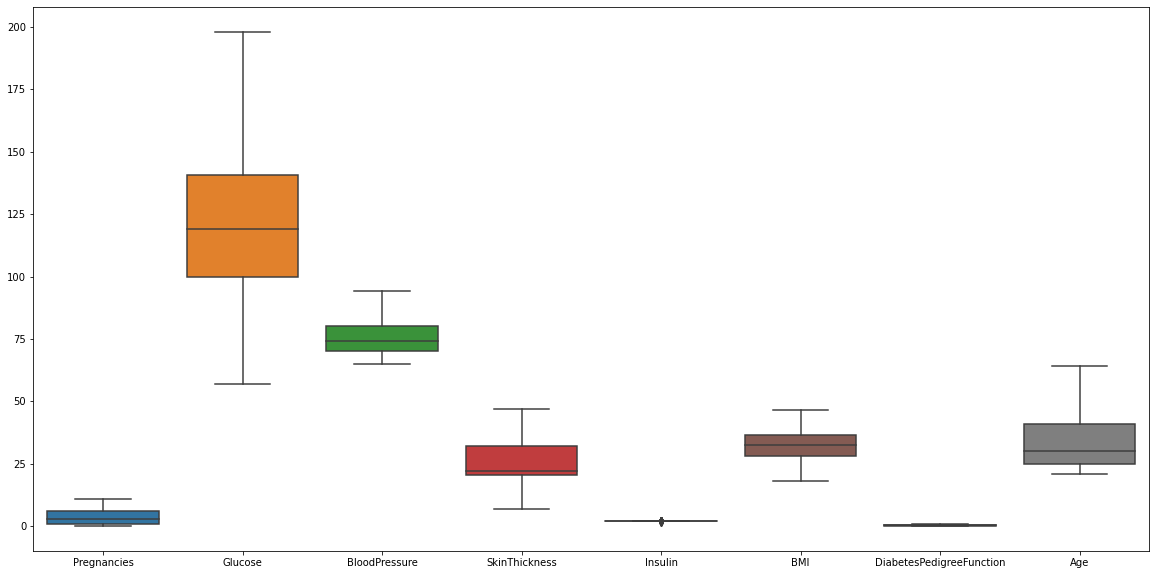

In [42]:
fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = X)

### # Another Approach: 

In [43]:
def outlier_removal(data):
        def outlier_limits(col):
            Q3, Q1 = np.nanpercentile(col, [75,25])
            IQR= Q3-Q1
            UL= Q3+1.5*IQR
            LL= Q1-1.5*IQR
            return UL, LL

        for column in data.columns:
            if data[column].dtype != 'int64':
                UL, LL= outlier_limits(data[column])
                data[column]= np.where((data[column] > UL) | (data[column] < LL), np.nan, data[column])

        return data

In [44]:
df_new.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [45]:
df_n = outlier_removal(df)
df_n

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,NaN,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.000000,79.799479,36.8,0.340,27,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,20.536458,79.799479,30.1,0.349,47,1


In [46]:
df_n[df_n['Insulin'].isnull().values]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197.0,70.0,45.0,NaN,30.5,0.158,53,1
13,1,189.0,60.0,23.0,NaN,30.1,0.398,59,1
16,0,118.0,84.0,47.0,NaN,45.8,0.551,31,1
20,3,126.0,88.0,41.0,NaN,39.3,0.704,27,0
31,3,158.0,76.0,36.0,NaN,31.6,0.851,28,1
...,...,...,...,...,...,...,...,...,...
713,0,134.0,58.0,20.0,NaN,26.4,0.352,21,0
715,7,187.0,50.0,33.0,NaN,33.9,0.826,34,1
721,1,114.0,66.0,36.0,NaN,38.1,0.289,21,0
748,3,187.0,70.0,22.0,NaN,36.4,0.408,36,1


In [47]:
X_n = df_n.drop(columns=['Outcome'])
Y_N = df_n[['Outcome']]

In [48]:
X_n.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [49]:
X_n.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.000000,168.000000,43.1,NaN,33


In [50]:
def impute_them_all():
    def impute(col):
        X_n[col].mask(X_n[col].isnull(), X_n[col].median(), inplace=True)
    
    for i in X_n.columns:
        impute(i)

In [51]:
impute_them_all()

In [52]:
ProfileReport(X_n).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

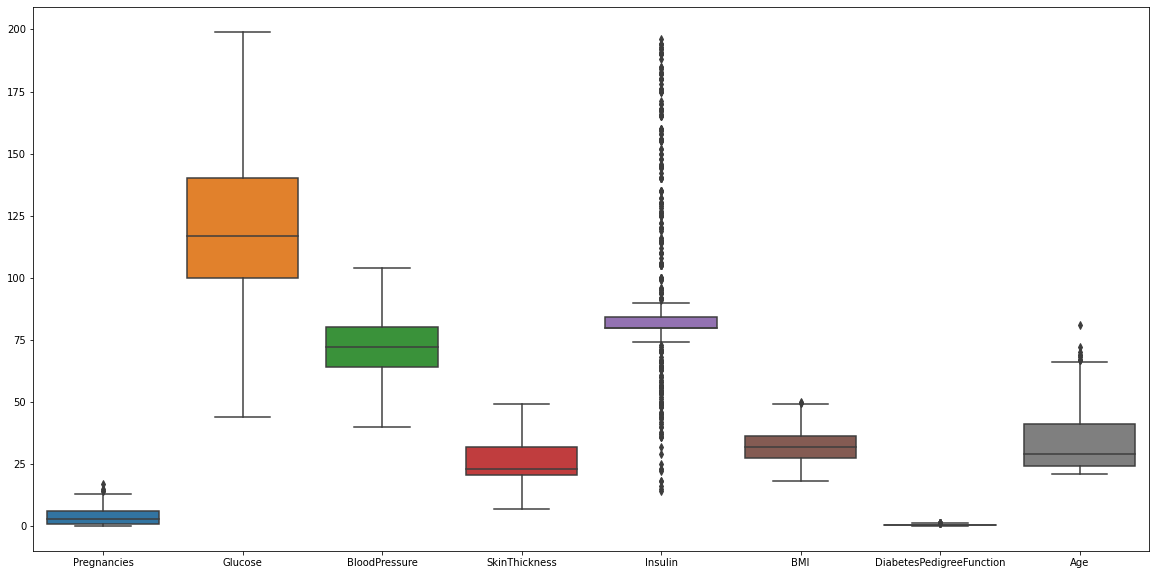

In [53]:
plt.fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(data = X_n, ax=ax)

## # Continuing the prior approach (the one using box plot): 

### # Standardizing: 

In [54]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.000000,35.000000,2.013489,33.6,0.627,50
1,1,85.0,66.000000,29.000000,2.013489,26.6,0.351,31
3,1,89.0,66.000000,23.000000,2.039035,28.1,0.167,21
5,5,116.0,74.000000,20.536458,2.013489,25.6,0.201,30
7,10,115.0,69.105469,20.536458,2.013489,35.3,0.134,29
...,...,...,...,...,...,...,...,...
758,1,106.0,76.000000,20.536458,2.013489,37.5,0.197,26
761,9,170.0,74.000000,31.000000,2.013489,44.0,0.403,43
764,2,122.0,70.000000,27.000000,2.013489,36.8,0.340,27
765,5,121.0,72.000000,23.000000,2.064502,26.2,0.245,30


In [48]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X)
# X_.columns = X.columns
X_

array([[ 0.68685931,  0.88538116, -0.52360762, ...,  0.20246007,
         1.16417471,  1.53945405],
       [-0.9360214 , -1.24736747, -1.34691951, ..., -0.94340796,
        -0.18399275, -0.24099329],
       [-0.9360214 , -1.11195486, -1.34691951, ..., -0.69786481,
        -1.08277105, -1.17807084],
       ...,
       [-0.61144526,  0.00519919, -0.79804492, ...,  0.72628545,
        -0.23772406, -0.61582431],
       [ 0.36228316, -0.02865397, -0.52360762, ..., -1.00888614,
        -0.7017672 , -0.33470105],
       [-0.9360214 , -0.97654225, -0.79804492, ..., -0.32136532,
        -0.35984067, -0.99065533]])

In [49]:
pd.DataFrame(X_, columns = X.columns).iplot(kind='hist', subplots=True)

<AxesSubplot:>

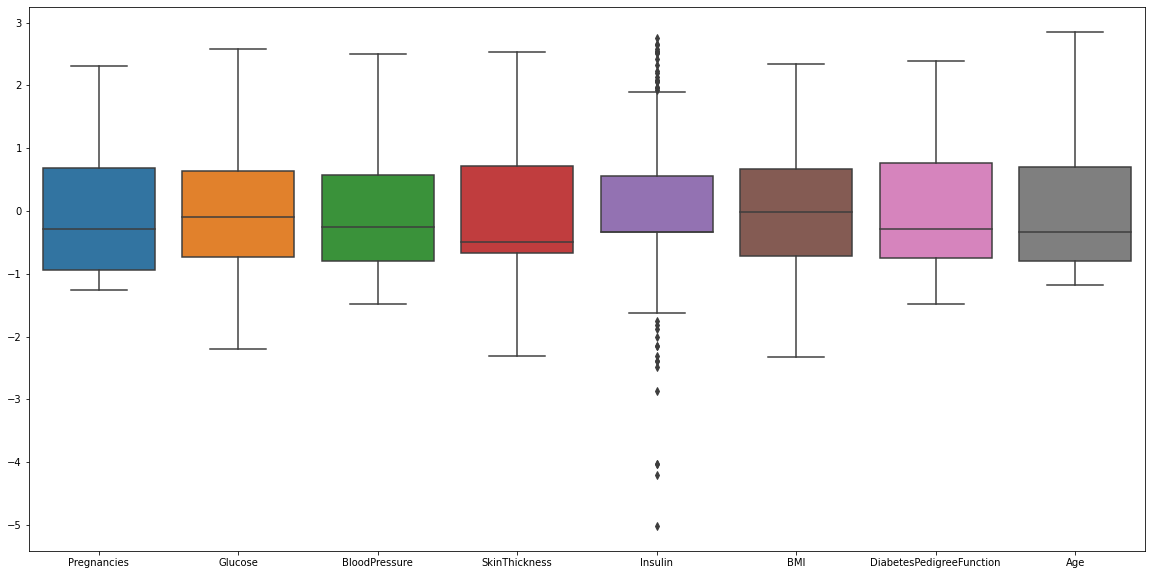

In [50]:
plt.fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(data = pd.DataFrame(X_, columns = X.columns), ax=ax)

In [51]:
pd.DataFrame(X_, columns = X.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.686859,0.885381,-0.523608,1.081467,-0.341411,0.202460,1.164175,1.539454
1,-0.936021,-1.247367,-1.346920,0.354271,-0.341411,-0.943408,-0.183993,-0.240993
2,-0.936021,-1.111955,-1.346920,-0.372926,0.017267,-0.697865,-1.082771,-1.178071
3,0.362283,-0.197920,-0.249170,-0.671506,-0.341411,-1.107103,-0.916692,-0.334701
4,1.985164,-0.231773,-0.920791,-0.671506,-0.341411,0.480742,-1.243965,-0.428409
...,...,...,...,...,...,...,...,...
434,-0.936021,-0.536451,0.025267,-0.671506,-0.341411,0.840872,-0.936231,-0.709532
435,1.660588,1.630151,-0.249170,0.596669,-0.341411,1.904893,0.070010,0.883500
436,-0.611445,0.005199,-0.798045,0.111872,-0.341411,0.726285,-0.237724,-0.615824
437,0.362283,-0.028654,-0.523608,-0.372926,0.374825,-1.008886,-0.701767,-0.334701


In [52]:
pd.DataFrame(X_, columns = X.columns).corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.132143,0.068644,0.043875,0.064110,-0.015451,0.018086,0.551366
Glucose,0.132143,1.000000,0.132783,0.100617,0.412991,0.166103,0.063574,0.227602
BloodPressure,0.068644,0.132783,1.000000,0.111136,0.079159,0.193998,0.073538,0.192597
SkinThickness,0.043875,0.100617,0.111136,1.000000,0.325424,0.492675,0.064217,0.007851
Insulin,0.064110,0.412991,0.079159,0.325424,1.000000,0.230075,0.140598,0.125349
BMI,-0.015451,0.166103,0.193998,0.492675,0.230075,1.000000,0.063007,-0.018607
DiabetesPedigreeFunction,0.018086,0.063574,0.073538,0.064217,0.140598,0.063007,1.000000,0.051628
Age,0.551366,0.227602,0.192597,0.007851,0.125349,-0.018607,0.051628,1.000000


<AxesSubplot:>

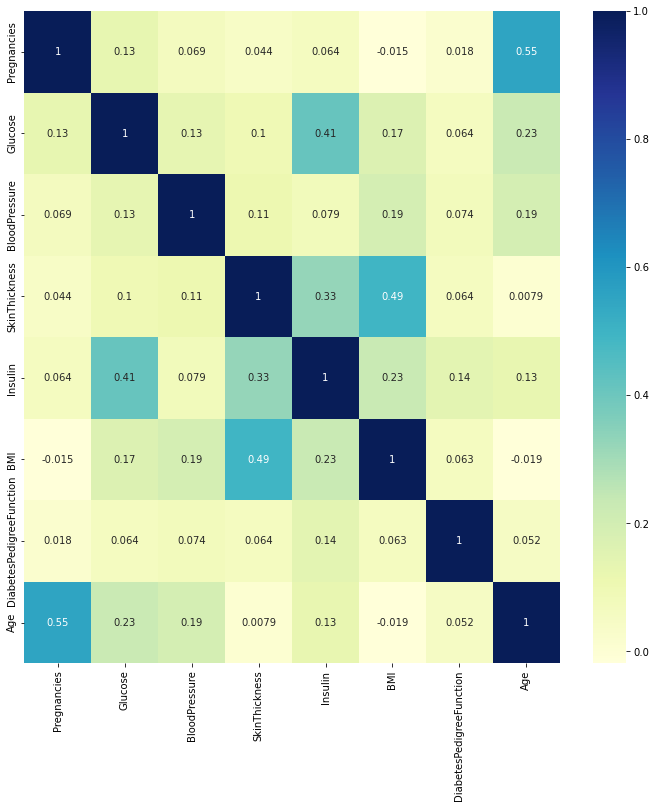

In [53]:
fig = plt.figure()

fig.set_size_inches(12, 12)

sns.heatmap(data = pd.DataFrame(X_, columns = X.columns).corr(), cmap="YlGnBu", annot=True)

In [54]:
X_

array([[ 0.68685931,  0.88538116, -0.52360762, ...,  0.20246007,
         1.16417471,  1.53945405],
       [-0.9360214 , -1.24736747, -1.34691951, ..., -0.94340796,
        -0.18399275, -0.24099329],
       [-0.9360214 , -1.11195486, -1.34691951, ..., -0.69786481,
        -1.08277105, -1.17807084],
       ...,
       [-0.61144526,  0.00519919, -0.79804492, ...,  0.72628545,
        -0.23772406, -0.61582431],
       [ 0.36228316, -0.02865397, -0.52360762, ..., -1.00888614,
        -0.7017672 , -0.33470105],
       [-0.9360214 , -0.97654225, -0.79804492, ..., -0.32136532,
        -0.35984067, -0.99065533]])

In [55]:
def vif_score(x):
    scaler = StandardScaler()
    arr = scaler.fit_transform(x)
    return pd.DataFrame([[x.columns[i], variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], columns=["FEATURE", "VIF_SCORE"])

In [56]:
vif_score(pd.DataFrame(X_))  # to drop any of 'em, that column must contain its val greater than 10

,FEATURE,VIF_SCORE
0,0,1.446097
1,1,1.278162
2,2,1.092300
3,3,1.425388
4,4,1.359288
5,5,1.388202
6,6,1.025527
7,7,1.546972


In [57]:
x_train, x_test, y_train , y_test = train_test_split(X_, Y, test_size=.20, random_state = 144)

In [58]:
x_train

array([[-0.9360214 , -0.46874495,  1.67189074, ..., -0.86156025,
         0.05535582, -0.89694758],
       [-0.9360214 , -1.41663323, -0.24917033, ..., -0.38684349,
         0.67570824, -1.08436309],
       [-1.26059754,  2.00253521,  1.67189074, ...,  1.79030577,
        -0.81411449, -0.70953207],
       ...,
       [-1.26059754, -0.80727648,  0.84857885, ..., -1.17258157,
        -0.43799531, -1.08436309],
       [-0.9360214 ,  1.52859107, -0.24917033, ..., -1.46723335,
         0.28493506, -0.05357778],
       [-0.61144526, -0.33333234,  1.39745344, ...,  0.98819815,
        -0.69688254, -0.52211656]])

In [59]:
y_train

600    0
432    0
753    1
669    0
451    1
      ..
225    0
734    0
376    0
646    1
620    0
Name: Outcome, Length: 351, dtype: int64

In [60]:
x_test

array([[-0.28686912, -0.06250712, -0.79804492,  0.47546996,  0.72833187,
         1.7248276 ,  0.30935839, -0.33470105],
       [-0.9360214 , -0.16406658,  1.67189074, -0.25172667,  0.85647178,
         0.34978596,  0.07000982,  0.6023765 ],
       [ 0.36228316, -1.21351432, -1.07248221,  0.23307109, -0.61266091,
        -0.3541044 , -0.1204921 , -0.89694758],
       [ 0.68685931, -1.24736747,  0.29970426, -0.67150597, -0.34141139,
        -0.19040897, -0.03256814,  0.78979201],
       [ 0.36228316,  0.85152801, -0.11195168, -0.67150597, -0.34141139,
        -0.40321303,  0.22143442, -0.52211656],
       [-0.28686912, -0.33333234, -0.24917033,  0.47546996, -0.34141139,
        -0.1249308 , -0.93623111, -0.80323982],
       [ 0.36228316,  0.47914333,  1.12301615,  1.80866378, -0.12424737,
         0.43163367, -0.50149595,  0.13383773],
       [-0.9360214 ,  1.96868205, -0.92079129, -0.67150597, -0.34141139,
         1.79030577, -0.52103461,  0.69608426],
       [ 1.66058773,  0.7838217 

In [61]:
y_test

126    0
128    1
457    0
176    0
437    0
      ..
480    1
725    0
740    1
562    0
42     0
Name: Outcome, Length: 88, dtype: int64

#### Does Logistic regression implement any Regularization modes?

Yes, it does. It implements all threee regularization modes by itself based on the solver selected at hand.

In [62]:
log_r = LogisticRegression()

#### For multi-classes classification i.e. `multinomial` classification, what loss function is used?!

`Categorical Cross-Entropy Loss`

**Note:** Currently the `multinomial` option is supported only by the `lbfgs`, `sag`, `saga` and `newton-cg` solvers.

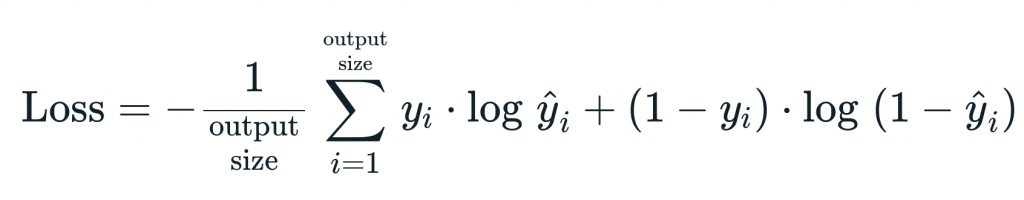

- `liblinear` solver can't be used for multi-class classification.
<br><br>
- For small datasets, `liblinear` is a good choice, whereas `sag` and `saga` are faster for large ones.
<br><br>
- For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
<br><br>
- `liblinear` is limited to one-versus-rest schemes.

As such, the choice of the algorithm depends on the penalty chosen. Supported penalties are:

- `newton-cg` - [‘l2’, ‘none’]
<br><br>
- `lbfgs` - [‘l2’, ‘none’]
<br><br>
- `liblinear` - [‘l1’, ‘l2’]
<br><br>
- `sag` - [‘l2’, ‘none’]
<br><br>
- `saga` - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [63]:
log_r = LogisticRegression(verbose=1)

In [64]:
x_train

array([[-0.9360214 , -0.46874495,  1.67189074, ..., -0.86156025,
         0.05535582, -0.89694758],
       [-0.9360214 , -1.41663323, -0.24917033, ..., -0.38684349,
         0.67570824, -1.08436309],
       [-1.26059754,  2.00253521,  1.67189074, ...,  1.79030577,
        -0.81411449, -0.70953207],
       ...,
       [-1.26059754, -0.80727648,  0.84857885, ..., -1.17258157,
        -0.43799531, -1.08436309],
       [-0.9360214 ,  1.52859107, -0.24917033, ..., -1.46723335,
         0.28493506, -0.05357778],
       [-0.61144526, -0.33333234,  1.39745344, ...,  0.98819815,
        -0.69688254, -0.52211656]])

In [65]:
log_r.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(verbose=1)

In [66]:
log_r.score(x_train, y_train)*100

78.06267806267806

In [67]:
log_r.score(x_test, y_test)*100

78.4090909090909

In [68]:
log_r.predict([[-0.611445, 0.411437, -0.798045, 0.671506, -0.419890, -0.566908, 0.748978, 
                -0.990655]])

array([0], dtype=int64)

In [69]:
[x_test[0]]

[array([-0.28686912, -0.06250712, -0.79804492,  0.47546996,  0.72833187,
         1.7248276 ,  0.30935839, -0.33470105])]

### prediction for the 0th record of the x_test

In [70]:
log_r.predict([x_test[0]])

array([1], dtype=int64)

In [71]:
log_r.predict_proba([x_test[0]])

array([[0.43044016, 0.56955984]])

In [72]:
y_test.iloc[0]

0

### prediction for the 2nd record of the x_test

In [73]:
log_r.predict([x_test[2]])

array([0], dtype=int64)

In [74]:
log_r.predict_proba([x_test[2]])

array([[0.92675688, 0.07324312]])

In [75]:
y_test.iloc[2]

0

In [76]:
log_r.predict([x_test[1]])

array([0], dtype=int64)

In [77]:
log_r.predict_proba([x_test[1]])

array([[0.75900441, 0.24099559]])

In [78]:
y_test.iloc[1]

1

### # building the model using `liblinear` solver:

In [79]:
log_ll = LogisticRegression(verbose=1, solver='liblinear')
log_ll

LogisticRegression(solver='liblinear', verbose=1)

In [80]:
log_ll.fit(x_train, y_train)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=1)

In [81]:
log_ll.score(x_test, y_test)*100

78.4090909090909

In [82]:
y_pred = log_r.predict(x_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [83]:
y_pred_ll = log_ll.predict(x_test)
y_pred_ll

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [84]:
confusion_matrix(y_test, y_pred)

array([[50,  8],
       [11, 19]], dtype=int64)

In [85]:
confusion_matrix(y_test, y_pred_ll)

array([[50,  8],
       [11, 19]], dtype=int64)

In [86]:
def model_eval(y_t, y_pred):
    tp, fp, fn, tn =  confusion_matrix(y_t, y_pred).ravel()
    
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    sensitivity = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    specificity = tn/(tn+fp)
    
    return {'accuracy': accuracy, 'sensitivity': sensitivity, 'precision': precision, 'f1': f1, 'specificity': specificity}

In [87]:
model_eval(y_test, y_pred)

{'accuracy': 0.7840909090909091,
 'sensitivity': 0.819672131147541,
 'precision': 0.8620689655172413,
 'f1': 0.8403361344537814,
 'specificity': 0.7037037037037037}

In [88]:
# for simple logistic regression

auc = roc_auc_score(y_test, y_pred)
auc

0.7477011494252873

In [89]:
# for liblinear logistic regression

auc_ll = roc_auc_score(y_test, y_pred_ll)
auc_ll

0.7477011494252873

In [90]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

[0.         0.13793103 1.        ] [0.         0.63333333 1.        ] [2 1 0]


In [91]:
fpr_ll, tpr_ll, thresholds_ll = roc_curve(y_test, y_pred)
print(fpr_ll, tpr_ll, thresholds_ll)

[0.         0.13793103 1.        ] [0.         0.63333333 1.        ] [2 1 0]


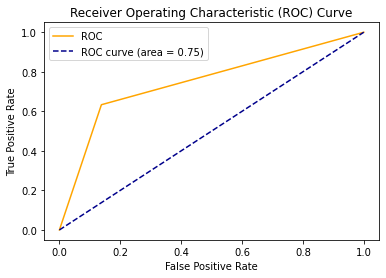

In [92]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

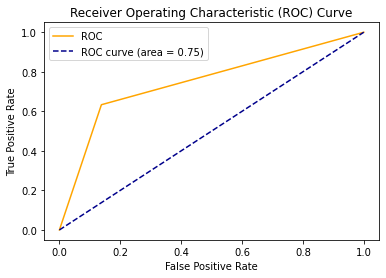

In [93]:
plt.plot(fpr_ll, tpr_ll, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()